In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Camera Calibration

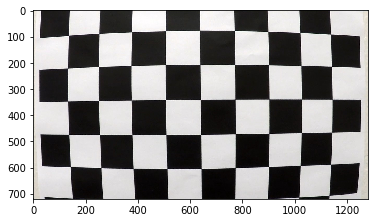

In [2]:
img = mpimg.imread('./camera_cal/calibration1.jpg')
plt.imshow(img)

Creation of object and image points

In [3]:
import glob
%matplotlib qt


objpoints = []
imgpoints = []

images = glob.glob('./camera_cal/calibration*.jpg')
objp = np.zeros((9*6,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

gray = None

for image in images:
    img = mpimg.imread(image)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #plt.imshow(gray,cmap='gray')
    ret,corners = cv2.findChessboardCorners(gray,(9,6),None)
    #rint(corners)
    #rint(ret)

    if ret==True:
        imgpoints.append(corners)
        objpoints.append(objp)
        cv2.drawChessboardCorners(img,(9,6),corners,ret)

Undistortion using camera matrix generated

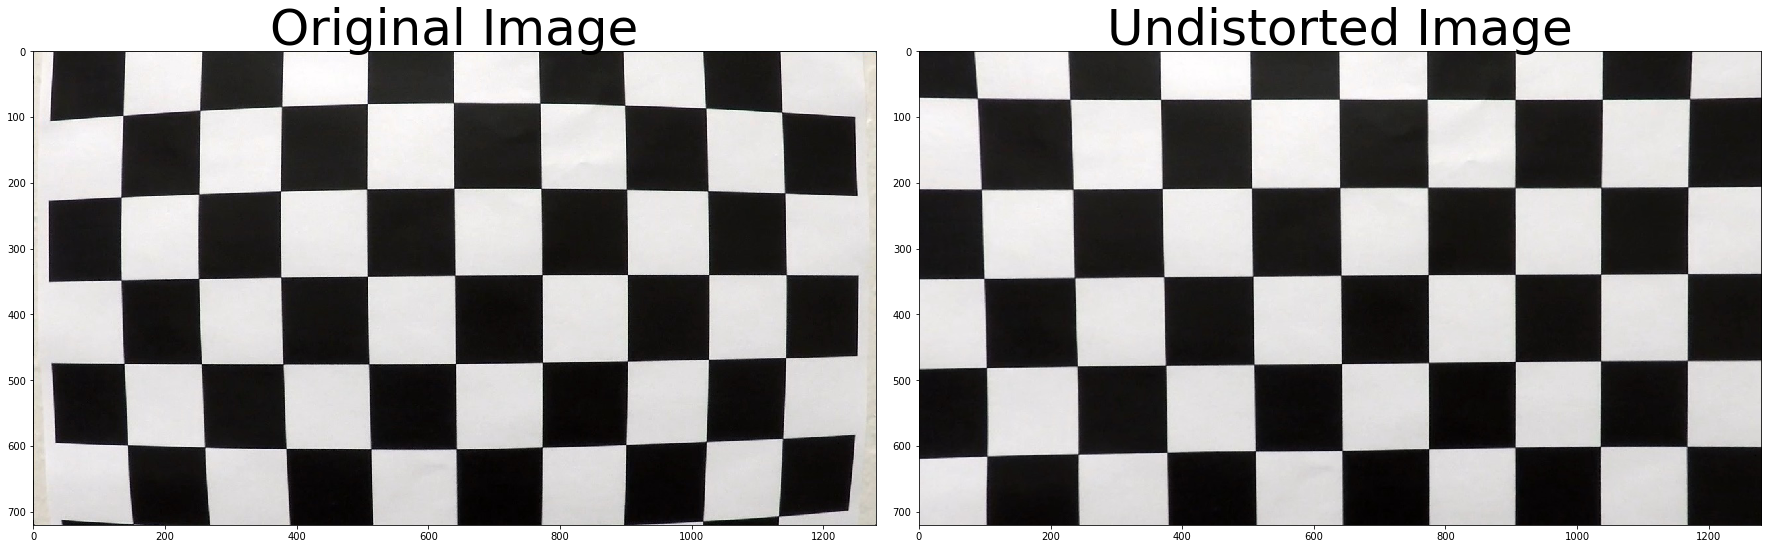

In [6]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
img = mpimg.imread('./camera_cal/calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("final_results/dist_corr.jpeg")

In [7]:
#Thresholding function for gradient along x axis
def abs_sobel_thresh(img, orient='x', sobel_kernel = 3,thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take Sobel x or y depending on orient
    if orient=='x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    # Rescale to 8 bit
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

#Thresholding function w.r.t gradient magnitude
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

#Thresholding function w.r.t gradient direction
def dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.3)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return binary_output

#Thresholding function w.r.t saturation channel of HLS converted image
def hls_binary(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    s_thresh_min = 200
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max) & (h_channel <= 100)] = 1
    #s_binary[500:]=0
    return s_binary

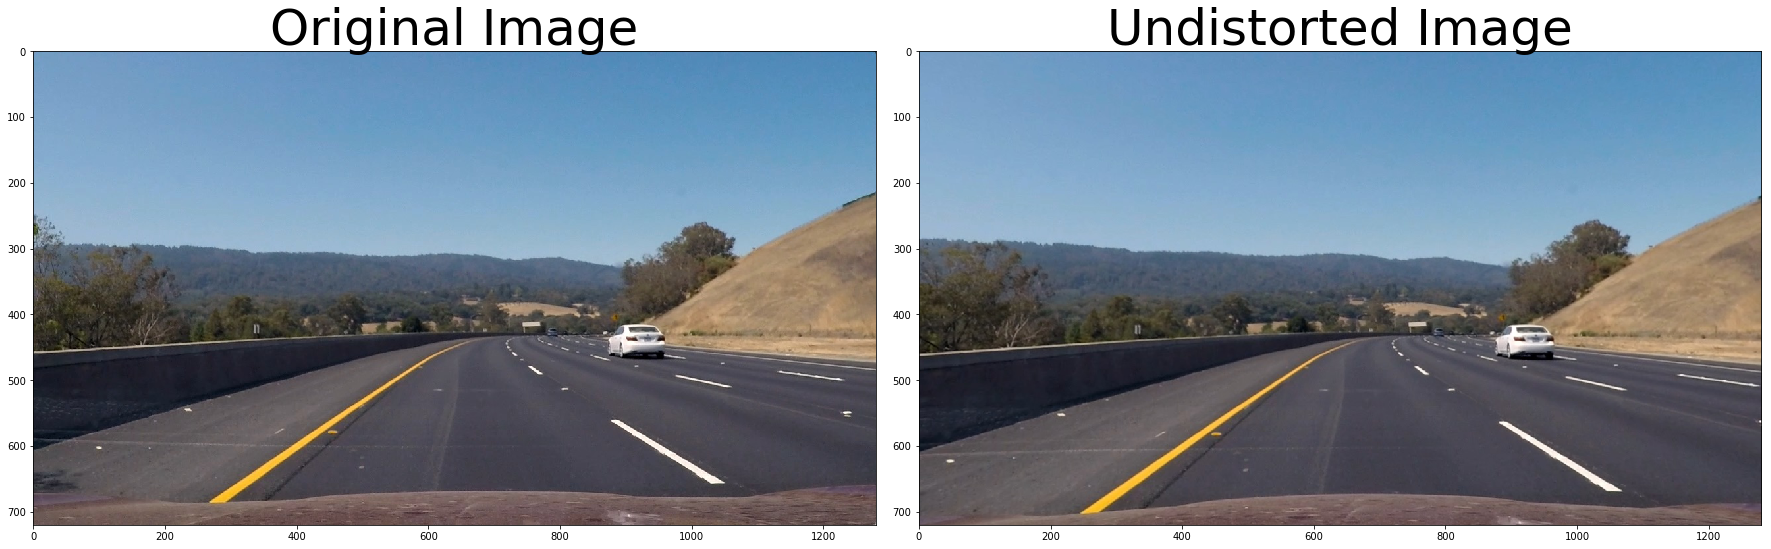

In [8]:
image = mpimg.imread('./test_images/test3.jpg')
img = cv2.undistort(image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Combination of the various thresholds

In [10]:
def combine(img):
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 255))#50,255
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(100, 255))#50,255
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(80, 255))#105,255
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.8, 1.0))#0.8,1.1
    combined = np.zeros_like(dir_binary,dtype=np.uint8)
    combined[(gradx == 1) & (dir_binary == 1)] = 1
    s_binary = hls_binary(img)
    combined2 = np.zeros_like(dir_binary,dtype=np.uint8)
    combined2[np.logical_or(combined==1,s_binary==1)] = 1
    combined2[np.logical_or(combined==1,((s_binary/np.max(s_binary))*255).astype(np.int)>150)] = 1
    return combined2

Functions required for image warping

In [11]:
def image_warp(img,M,X,Y):
    warped = cv2.warpPerspective(img, M, (X,Y),flags = cv2.INTER_NEAREST)
    return warped

def get_transform_matrix(img):
    x1=275
    y1=673
    y4=673
    x2=589
    y2=455
    x3=694
    y3=455
    x4=1032
    region = np.array([[x1,y1],[x2,y2],[x3,y3],[x4,y4]])
    src = np.float32([region[0],region[1],region[2],region[3]])
    Y = img.shape[0]
    X = img.shape[1]
    d = 290
    dst = np.float32([[d,720],[d,0],[X-d,0],[X-d,720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M,Minv

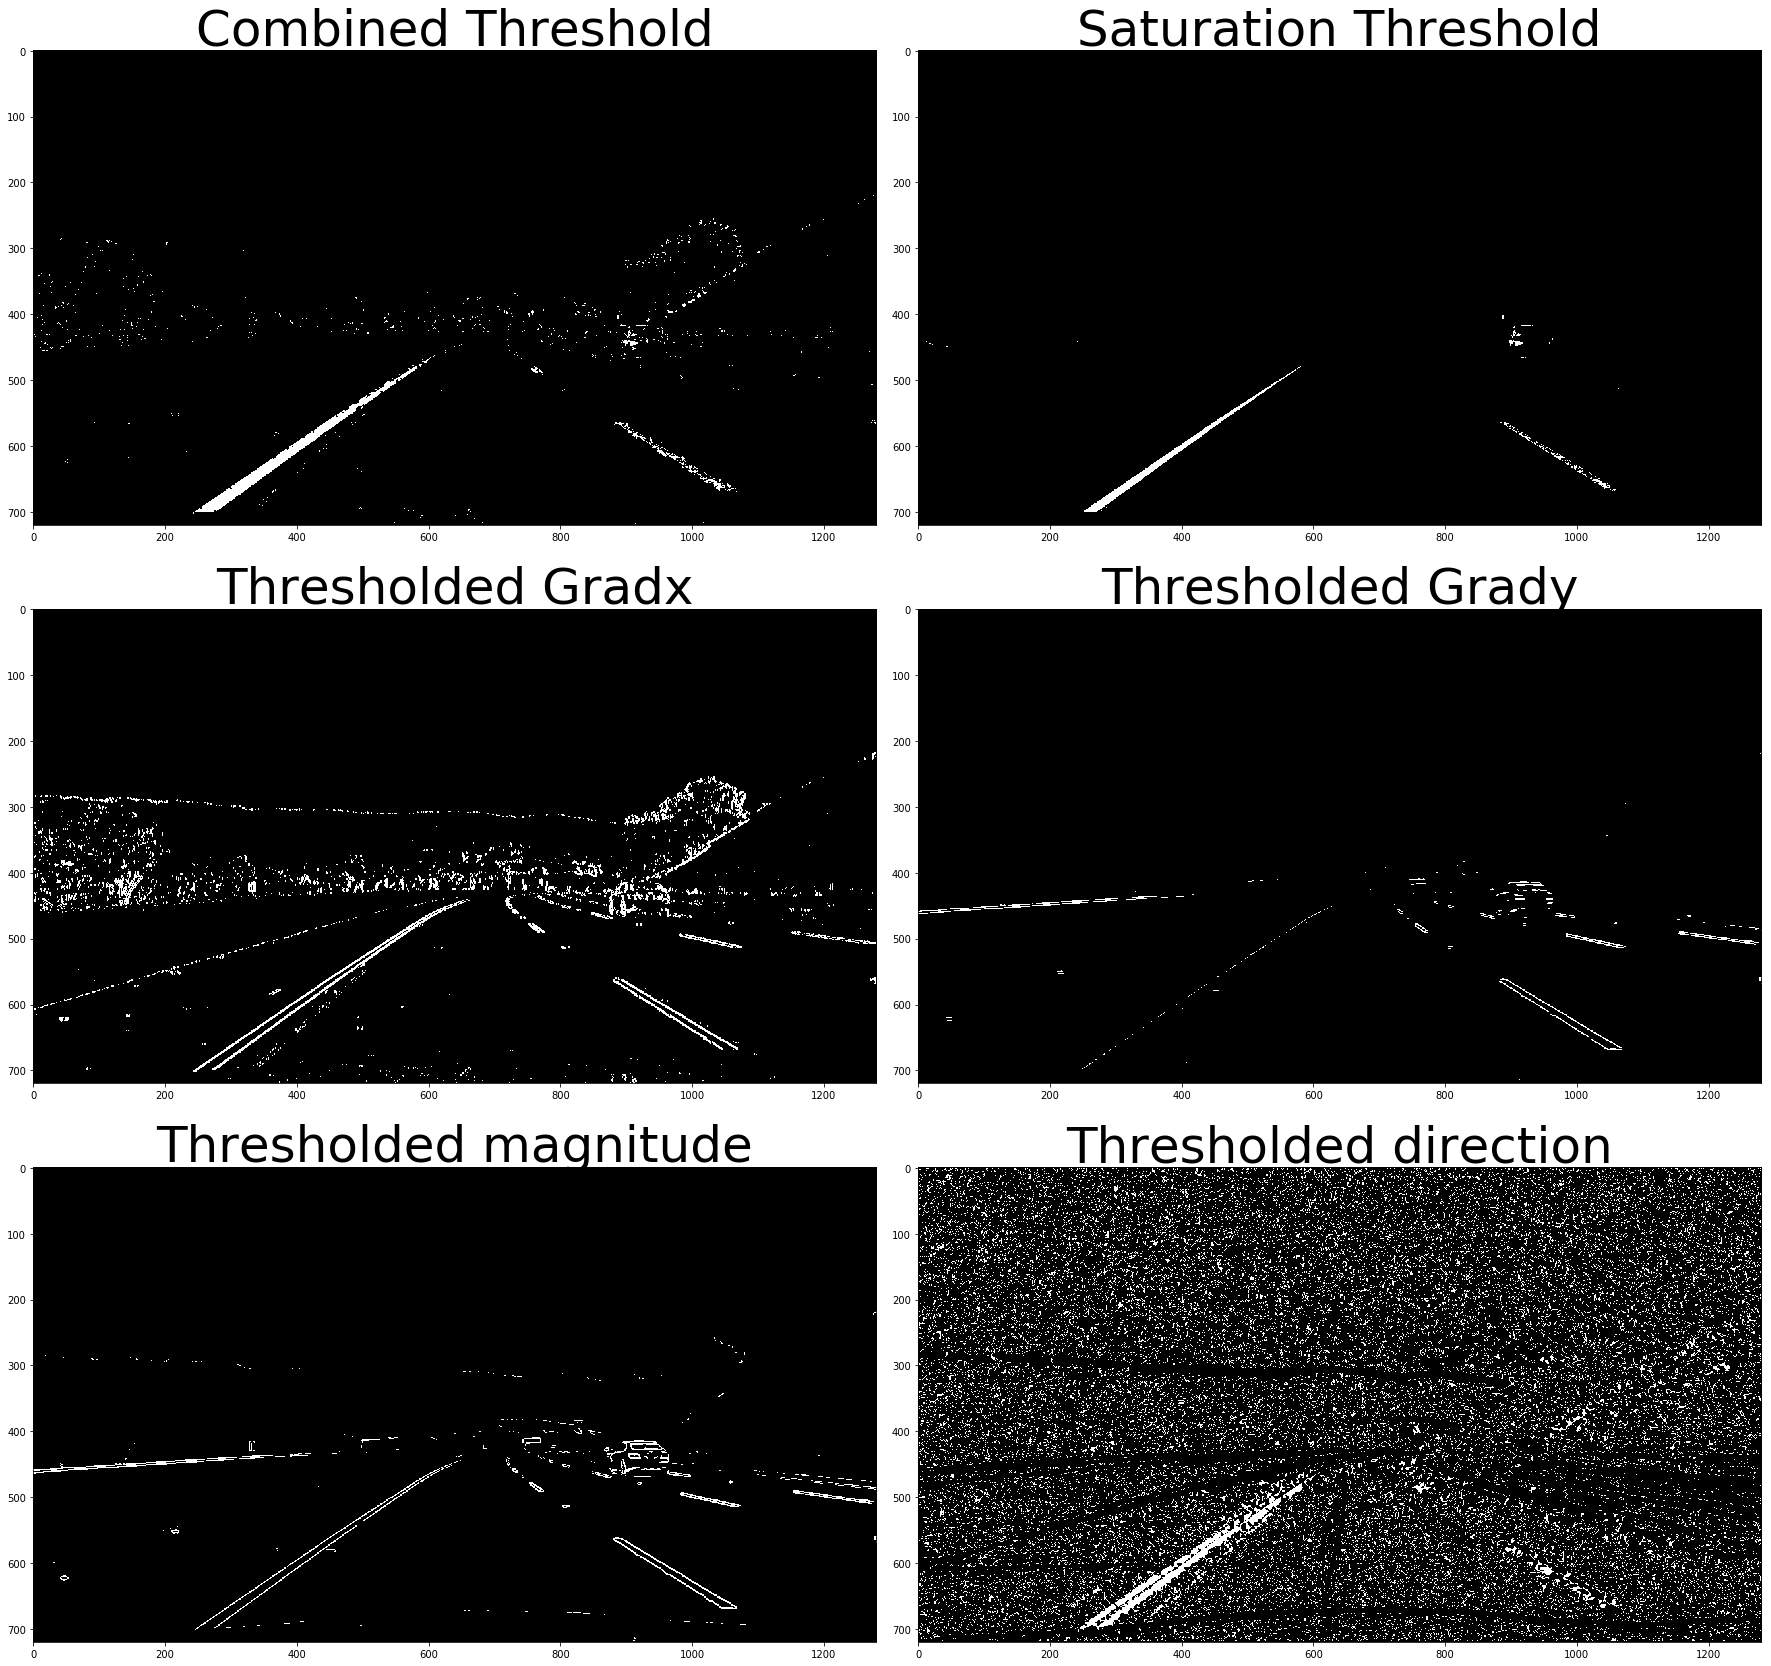

In [14]:
ksize = 3 # Choose a larger odd number to smooth gradient measurements
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 255))#50,255
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(100, 255))#50,255
mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(80, 255))#105,255
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.8, 1.0))#0.8,1.1
s_binary = hls_binary(img)
combined2 = combine(img)
f, (ax1r, ax2r,ax3r) = plt.subplots(3, 2, figsize=(24, 27))
ax1,ax2 = ax1r
ax3,ax4 = ax2r
ax5,ax6 = ax3r
f.tight_layout()
ax1.imshow(combined2,cmap = 'gray')
ax1.set_title('Combined Threshold', fontsize=50)
ax2.imshow(s_binary,cmap='gray')
ax2.set_title('Saturation Threshold', fontsize=50)
ax3.imshow(gradx, cmap='gray')
ax3.set_title('Thresholded Gradx', fontsize=50)
ax4.imshow(grady, cmap='gray')
ax4.set_title('Thresholded Grady', fontsize=50)
ax5.imshow(mag_binary, cmap='gray')
ax5.set_title('Thresholded magnitude', fontsize=50)
ax6.imshow(dir_binary, cmap='gray')
ax6.set_title('Thresholded direction', fontsize=50)
f.tight_layout()
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("final_results/binary.jpeg")

Warping results

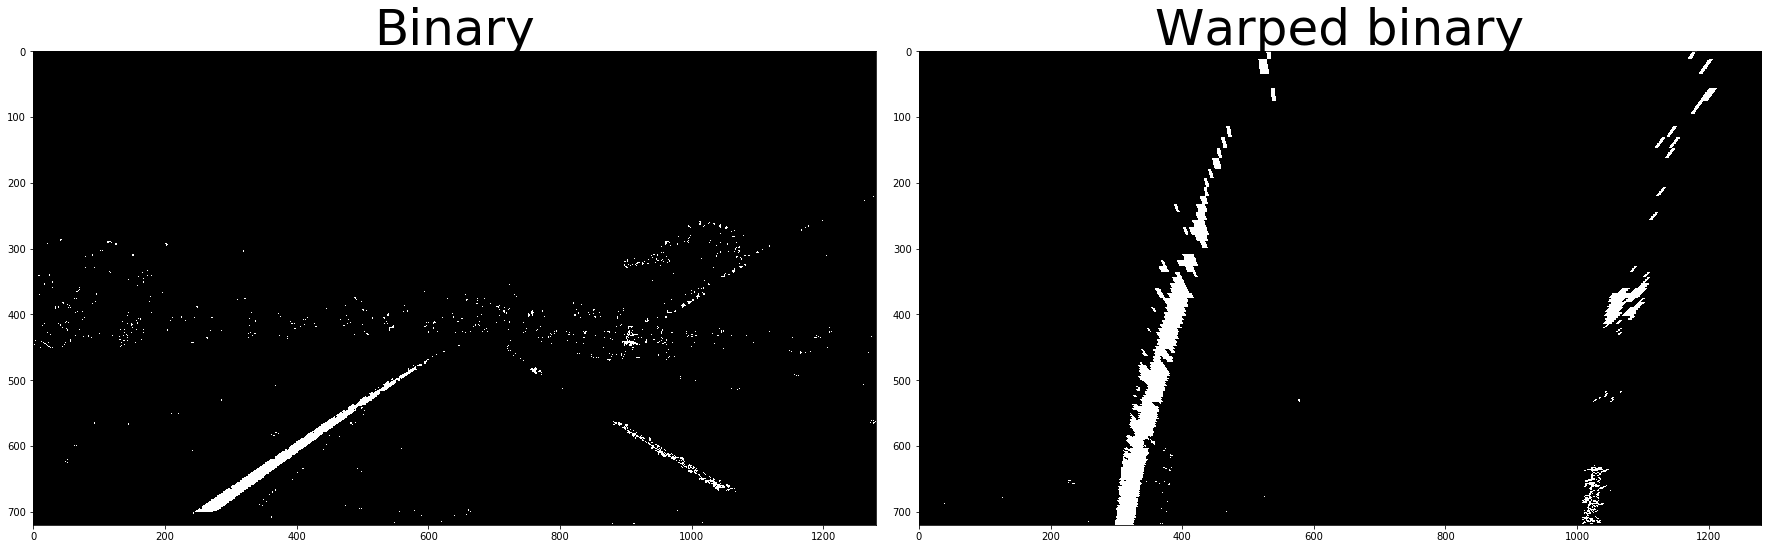

In [15]:
Y = img.shape[0]
X = img.shape[1]
thresh_binary = combine(img)
M,Minv = get_transform_matrix(image)
binary_warped = image_warp(thresh_binary,M,X,Y)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(thresh_binary,cmap='gray')
ax1.set_title('Binary', fontsize=50)
ax2.imshow(binary_warped,cmap='gray')
ax2.set_title('Warped binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("final_results/Warped.jpeg")

Functions to detect lane pixels and fit polynomial. Using the results of these we also find the radius of curvature and distance from center. 

In [21]:
def find_lane_pixels(binary_warped,leftx_base,rightx_base):
    #global leftx_base,rightx_base
    # Take a histogram of the bottom half of the image
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    nwindows = 9
        # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    window_height = np.int(binary_warped.shape[0]//nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = []
    right_lane_inds = []
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 10) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 10) 

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty, out_img,leftx_base,rightx_base

def find_curvature(left_fit_cr,right_fit_cr,ym_per_pix,xm_per_pix):
    y_eval = 719.0
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curverad = (left_curverad+right_curverad)/2
    return left_curverad,right_curverad,curverad

def centerdist(xm_per_pix):
    global leftx_base,rightx_base
    distfromcenter = ((rightx_base-leftx_base)/2+leftx_base-640)*xm_per_pix
    return distfromcenter
leftx_base = None
rightx_base = None
def fit_polynomial(binary_warped):
    global leftx_base,rightx_base
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img,leftx_base,rightx_base = find_lane_pixels(binary_warped,leftx_base,rightx_base)
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    y_eval = np.max(ploty)
    lcurve,rcurve,curve = find_curvature(left_fit_cr,right_fit_cr,ym_per_pix,xm_per_pix)
    cent = centerdist(xm_per_pix)
    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img,lcurve,rcurve,curve,cent,left_fit,right_fit

Output of the above functions.

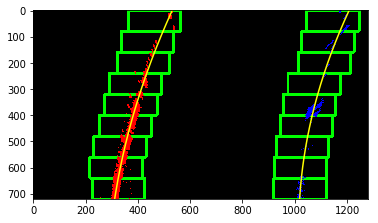

In [18]:
out_img,lcurve,rcurve,curve,cent,left_fit,right_fit = fit_polynomial(binary_warped)
plt.imshow(out_img)
plt.savefig("final_results/poly.jpeg")

Functions to draw the lanes and display radius of curvature and distance from center

In [19]:
frame_no = 0
def draw_lanes(img,left_fit,right_fit,Minv):
    global left_lane_old,right_lane_old,frame_no
    if(frame_no==0):
        left_lane_old = left_fit
        right_lane_old = right_fit
    else:
        left_lane_old = 0.9*left_lane_old + 0.1*left_fit
        right_lane_old = 0.9*right_lane_old + 0.1*right_fit
    colored_lanes = np.zeros_like(img).astype(np.uint8)
    ploty = np.linspace(0, colored_lanes.shape[0]-1, colored_lanes.shape[0])
    fitxL = left_lane_old[0]*ploty**2 + left_lane_old[1]*ploty + left_lane_old[2]
    fitxR = right_lane_old[0]*ploty**2 + right_lane_old[1]*ploty + right_lane_old[2]
    ptsx = np.array([np.vstack((fitxL,ploty)).astype(np.int32).T])
    ptsy = np.array([np.flipud(np.vstack((fitxR,ploty)).astype(np.int32).T)])
    pts = np.hstack((ptsx,ptsy))
    cv2.fillPoly(colored_lanes, np.int_([pts]), (0,255, 0))
    cv2.polylines(colored_lanes, np.int32([ptsx]), isClosed=False, color=(255,0,0), thickness=45)
    cv2.polylines(colored_lanes, np.int32([ptsy]), isClosed=False, color=(0,0,255), thickness=45)
    newwarp = cv2.warpPerspective(colored_lanes, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

def showdata(laneimg, curverad, distfromcenter):
    new_img = np.copy(laneimg)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Radius of Curvature: ' + '{:04.2f}'.format(curverad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if distfromcenter > 0:
        direction = 'right'
    elif distfromcenter < 0:
        direction = 'left'
    else:
        direction = 'middle'
    abs_center_dist = abs(distfromcenter)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

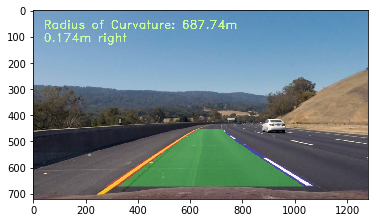

In [20]:
out_img = draw_lanes(img,left_fit,right_fit,Minv)
out_img = showdata(out_img,curve,cent)
plt.imshow(out_img)
plt.savefig("final_results/final.jpeg")

Final function combining the pipeline and will be used for the video

In [22]:
def mark_lanes(image):
    global frame_no,leftx_base,rightx_base
    img = cv2.undistort(image, mtx, dist, None, mtx)
    thresh_binary = combine(img)
    pts = np.array([[200,700],[600,400],[800,400],[1200,700]], np.int32)
    pts = pts.reshape((-1,1,2))
    img = cv2.polylines(img,[pts],False,(0,255,255))
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    mask_trap=np.zeros_like(img_gray)
    cv2.fillPoly(mask_trap,[pts],255)
    thresh_binary[mask_trap==0] = 0
    M,Minv = get_transform_matrix(image)
    Y = img.shape[0]
    X = img.shape[1]
    binary_warped = image_warp(thresh_binary,M,X,Y)
#     final_warped_red = np.zeros_like(image)
#     final_warped_red[binary_warped>0,:] = 255
    out_img,lcurve,rcurve,curve,cent,left_fit,right_fit = fit_polynomial(binary_warped)
    out_img = draw_lanes(image,left_fit,right_fit,Minv)
    out_img = showdata(out_img,curve,cent)
    frame_no = frame_no+1
    return out_img

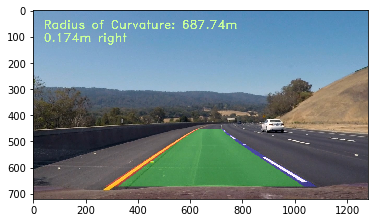

In [23]:
out_img = mark_lanes(image)
plt.imshow(out_img)

In [24]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [25]:
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(mark_lanes) #NOTE: this function expects color images!!
#clip1.write_videofile(white_output, audio=False)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:51<00:00,  7.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 5min 55s, sys: 1min 6s, total: 7min 2s
Wall time: 2min 52s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))